In [1]:
import sys
sys.path.append("../library")

In [2]:
from __future__ import print_function, division
import scipy
import pandas as pd
import math
import random
import numpy as np
from thinkbayes2 import Suite, Joint, Pmf, EvalNormalPdf, StandardNormalCdf, MakeCdfFromList, \
    Mean, Jitter, PmfProbGreater, MakeCdfFromPmf
import matplotlib.pyplot as plt
import thinkplot

# for reading data out
import brfss

# global sigmas number
NUM_SIGMAS = 1

In [3]:
def MedianIPR(xs, p):
    """
    Computes the median and interpercentile range.
    xs: sequence of values
    p: range (0-1), 0.5 yields the interquartile range
    returns: tuple of float (median, IPR)
    """
    cdf = MakeCdfFromList(xs)
    median = cdf.Percentile(50)

    alpha = (1-p) / 2
    ipr = cdf.Value(1-alpha) - cdf.Value(alpha)
    return median, ipr

def MedianS(xs, num_sigmas):
    """Computes the median and an estimate of sigma.
    Based on an interpercentile range (IPR).
    factor: number of standard deviations spanned by the IPR
    """
    half_p = StandardNormalCdf(num_sigmas) - 0.5
    median, ipr = MedianIPR(xs, half_p * 2)
    s = ipr / 2 / num_sigmas
    return median, s

In [4]:
def CoefVariation(suite):
    """Computes the distribution of CV.
    suite: Pmf that maps (x, y) to z
    Returns: Pmf object for CV.
    """
    pmf = Pmf()
    for (m, s), p in suite.Items():
        pmf.Incr(s/m, p)
    return pmf

In [5]:
def EvalNormalLogPdf(x, mu, sigma):
    """Computes the log PDF of x given mu and sigma.
    x: float values
    mu, sigma: paramemters of Normal
    returns: float log-likelihood
    """
    return scipy.stats.norm.logpdf(x, mu, sigma)

In [6]:
def Summation(xs, mu, cache={}):
    """Computes the sum of (x-mu)**2 for x in t.
    Caches previous results. DP programming to avoid repeated calculation.
    xs: tuple of values
    mu: hypothetical mean
    cache: cache of previous results
    """
    try:
        return cache[xs, mu]
    except KeyError:
        ds = [(x-mu)**2 for x in xs]
        total = sum(ds)
        cache[xs, mu] = total
        return total

In [7]:
def ReadHeights(nrows=None):
    """
    Read the BRFSS dataset, extract the heights and pickle them.
    nrows: number of rows to read
    """
    resp = brfss.ReadBrfss(nrows=nrows).dropna(subset=['sex', 'htm3'])
    groups = resp.groupby('sex')

    d = {}
    for name, group in groups:
        d[name] = group.htm3.values
    return d

In [8]:
def Summarize(xs):
    """
    Prints summary statistics from a sequence of values.
    xs: sequence of values
    """
    # print smallest and largest
    xs.sort()
    print('smallest', xs[:10])
    print('largest', xs[-10:])

    # print median and interquartile range
    cdf = MakeCdfFromList(xs)
    print(cdf.Percentile(25), cdf.Percentile(50), cdf.Percentile(75))

In [9]:
# refer to https://github.com/rlabbe/ThinkBayes2/blob/master/code/variability.py
class Height(Suite, Joint):
    """
    Analysis of height for men and women.
    """
    def __init__(self, mus, sigmas, label=None):
        """
        Construct [(mu, sigma)] for height gaussian distribution. Makes a prior distribution for mu and sigma based on a sample.
        mus: sequence of possible mus
        sigmas: sequence of possible sigmas
        label: string label for the Suite
        """
        pairs = [(mu, sigma) for mu in mus for sigma in sigmas]
        super().__init__(pairs, label=label)
    
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of the data under the hypothesis.
        Args:
            hypo: tuple of hypothetical mu and sigma
            data: float sample
        Returns:
            likelihood of the sample given mu and sigma
        """
        x = data
        mu, sigma = hypo
        like = EvalNormalPdf(x, mu, sigma)
        return like
    
    def LogLikelihood(self, data, hypo):
        """Computes the log likelihood of the data under the hypothesis.
        Args:
            data: a list of values
            hypo: tuple of hypothetical mu and sigma
        Returns:
            log likelihood of the sample given mu and sigma (unnormalized)
        """
        x = data
        mu, sigma = hypo
        loglike = EvalNormalLogPdf(x, mu, sigma)
        return loglike
    
    def LogUpdateSetFast(self, data):
        """Updates the suite using a faster implementation.
        Computes the sum of the log likelihoods directly.
        Args:
            data: sequence of values
        """
        xs = tuple(data)
        n = len(xs)

        for hypo in self.Values():
            mu, sigma = hypo
            total = Summation(xs, mu)
            loglike = -n * math.log(sigma) - total / 2 / sigma**2
            self.Incr(hypo, loglike)
            
    def LogUpdateSetMeanVar(self, data):
        """Updates the suite using ABC and mean/var.
        Args:
            data: sequence of values
        """
        xs = data
        n = len(xs)

        m = np.mean(xs)
        s = np.std(xs)

        self.LogUpdateSetABC(n, m, s)
        
    def LogUpdateSetMedianIPR(self, data):
        """Updates the suite using ABC and median/iqr.
        Args:
            data: sequence of values
        """
        xs = data
        n = len(xs)

        # compute summary stats
        median, s = MedianS(xs, num_sigmas=NUM_SIGMAS)
        print('median, s', median, s)

        self.LogUpdateSetABC(n, median, s)

    def LogUpdateSetABC(self, n, m, s):
        """Updates the suite using ABC.
        n: sample size
        m: estimated central tendency
        s: estimated spread
        """
        for hypo in sorted(self.Values()):
            mu, sigma = hypo

            # compute log likelihood of m, given hypo
            stderr_m = sigma / math.sqrt(n)
            loglike = EvalNormalLogPdf(m, mu, stderr_m)

            #compute log likelihood of s, given hypo
            stderr_s = sigma / math.sqrt(2 * (n-1))
            loglike += EvalNormalLogPdf(s, sigma, stderr_s)

            self.Incr(hypo, loglike)

In [10]:
def FindPriorRanges(xs, num_points, num_stderrs=3.0, median_flag=False):
    """
    Find ranges for mu and sigma with non-negligible likelihood.
    xs: sample
    num_points: number of values in each dimension
    num_stderrs: number of standard errors to include on either side
    
    Returns: sequence of mus, sequence of sigmas    
    """
    
    def MakeRange(estimate, stderr):
        """
        Makes a linear range around the estimate.
        estimate: central value
        stderr: standard error of the estimate
        returns: numpy array of float
        """
        spread = stderr * num_stderrs
        array = np.linspace(estimate-spread, estimate+spread, num_points)
        return array
    
    # estimate mean and stddev of xs
    n = len(xs)
    if median_flag:
        m, s = MedianS(xs, num_sigmas)
    else:
        m = np.mean(xs)
        s = np.std(xs)
    print('classical estimators: ', m, s)
    # compute ranges for m and s
    stderr_m = s / math.sqrt(n)
    mus = MakeRange(m, stderr_m)
    stderr_s = s / math.sqrt(2 * (n-1))
    sigmas = MakeRange(s, stderr_s)
    return mus, sigmas

In [11]:
def PlotCdfs(d, labels):
    """
    Plot CDFs for each sequence in a dictionary.
    Jitters the data and subtracts away the mean.
    d: map from key to sequence of values
    labels: map from key to string label
    """
    thinkplot.Clf()
    for key, xs in d.items():
        mu = Mean(xs)
        xs = Jitter(xs, 1.3)
        xs = [x-mu for x in xs]
        cdf = MakeCdfFromList(xs)
        # revise color of male to yellow, female to green
        thinkplot.Cdf(cdf, label=labels[key], color="C{}".format(key))
    thinkplot.Show()

In [12]:
def PlotPosterior(suite, pcolor=False, contour=True):
    """
    Makes a contour plot.
    
    suite: Suite that maps (mu, sigma) to probability
    """
    thinkplot.Clf()
    thinkplot.Contour(suite.GetDict(), pcolor=pcolor, contour=contour)
    thinkplot.Show()
#     thinkplot.Save(root='variability_posterior_%s' % suite.label,
#                 title='Posterior joint distribution',
#                 xlabel='Mean height (cm)',
#                 ylabel='Stddev (cm)')

In [13]:
def PlotCoefVariation(suites):
    """Plot the posterior distributions for CV.
    suites: map from label to Pmf of CVs.
    """
    thinkplot.Clf()
    thinkplot.PrePlot(num=2)

    pmfs = {}
    for label, suite in suites.items():
        pmf = CoefVariation(suite)
        print('CV posterior mean', pmf.Mean())
        cdf = MakeCdfFromPmf(pmf, label)
        thinkplot.Cdf(cdf)
        pmfs[label] = pmf

#     thinkplot.Save(root='variability_cv',
#                 xlabel='Coefficient of variation',
#                 ylabel='Probability')

    print('female bigger', PmfProbGreater(pmfs['female'], pmfs['male']))
    print('male bigger', PmfProbGreater(pmfs['male'], pmfs['female']))

In [14]:
def PlotMarginals(suite):
    """Plots marginal distributions from a joint distribution.
    suite: joint distribution of mu and sigma.
    """
    thinkplot.Clf()

    plt.subplot(1, 2, 1)
    pmf_m = suite.Marginal(0)
    cdf_m = MakeCdfFromPmf(pmf_m)
    thinkplot.Cdf(cdf_m)

    plt.subplot(1, 2, 2)
    pmf_s = suite.Marginal(1)
    cdf_s = MakeCdfFromPmf(pmf_s)
    thinkplot.Cdf(cdf_s)

    thinkplot.Show()

In [15]:
def RunEstimate(update_func, num_points=31, median_flag=False):
    """
    Runs the whole analysis.
    update_func: which of the update functions to use
    num_points: number of points in the Suite (in each dimension)
    """
    d = ReadHeights(nrows=None)
    labels = {1:'male', 2:'female'}
    PlotCdfs(d, labels)

    suites = {}
    for key, xs in d.items():
        label = labels[key]
        print(label, len(xs))
        Summarize(xs)

        xs = Jitter(xs, 1.3)

        mus, sigmas = FindPriorRanges(xs, num_points, median_flag=median_flag)
        suite = Height(mus, sigmas, label)
        suites[label] = suite
        update_func(suite, xs)
        print('MLE', suite.MaximumLikelihood())

        PlotPosterior(suite)

        pmf_m = suite.Marginal(0)
        pmf_s = suite.Marginal(1)
        print('marginal mu', pmf_m.Mean(), pmf_m.Var())
        print('marginal sigma', pmf_s.Mean(), pmf_s.Var())
        PlotMarginals(suite)

    PlotCoefVariation(suites)

In [16]:
def UpdateSuite1(suite, xs):
    """Computes the posterior distibution of mu and sigma.
    Computes untransformed likelihoods.
    suite: Suite that maps from (mu, sigma) to prob
    xs: sequence
    """
    suite.UpdateSet(xs)

In [17]:
def UpdateSuite2(suite, xs):
    """
    Computes the posterior distibution of mu and sigma.
    Computes log likelihoods.
    suite: Suite that maps from (mu, sigma) to prob
    xs: sequence
    """
    suite.Log()
    suite.LogUpdateSet(xs)
    suite.Exp()
    suite.Normalize()

In [18]:
def UpdateSuite3(suite, xs):
    """Computes the posterior distibution of mu and sigma.
    Computes log likelihoods efficiently.
    suite: Suite that maps from (mu, sigma) to prob
    t: sequence
    """
    suite.Log()
    suite.LogUpdateSetFast(xs)
    suite.Exp()
    suite.Normalize()

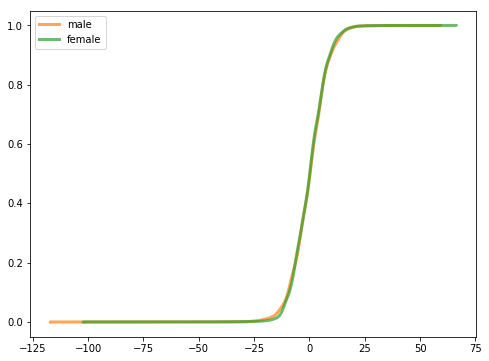

male 154407
smallest [  61.   74.   76.   81.   86.   89.   89.   91.   97.  101.]
largest [ 218.  221.  221.  221.  221.  225.  226.  229.  229.  236.]
173.0 178.0 183.0
classical estimators:  178.069612239 7.83346594062


/Users/llv23/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
No handles with labels found to put in legend.


MLE (178.06961223920615, 7.8334659406220366)


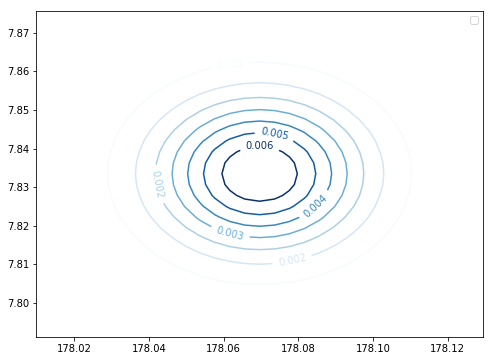

marginal mu 178.069612239 0.000389443658335
marginal sigma 7.83354834145 0.000194721308294


No handles with labels found to put in legend.


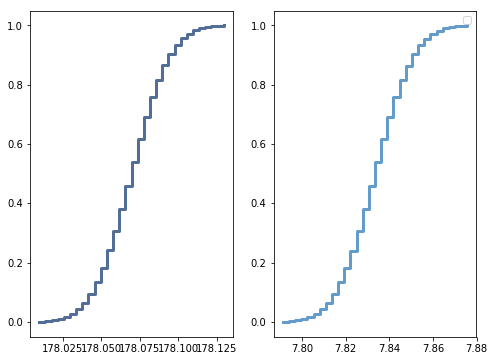

female 254722
smallest [ 61.  61.  64.  66.  74.  81.  89.  89.  89.  91.]
largest [ 213.  213.  213.  213.  221.  226.  229.  229.  229.  229.]
157.0 163.0 168.0
classical estimators:  163.223939415 7.38105143977


No handles with labels found to put in legend.


MLE (163.22393941467749, 7.3810514397749287)


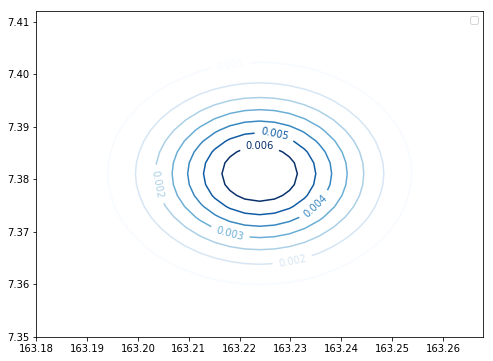

No handles with labels found to put in legend.


marginal mu 163.223939415 0.000209589897965
marginal sigma 7.3810985047 0.000104794779064


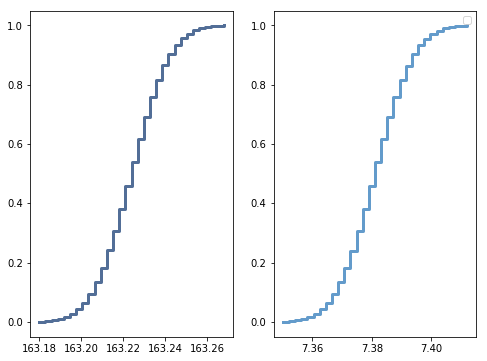

CV posterior mean 0.0439914948944
CV posterior mean 0.0452206863113
female bigger 1.0000000000000033
male bigger 0


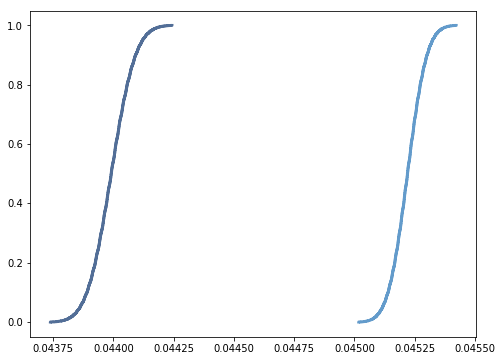

In [19]:
# Estimate 1: just using the same data
random.seed(17)
func = UpdateSuite1
median_flag = False
# case 1: very slow, can't get result out immediately => still about 1 hour
# RunEstimate(func, median_flag=median_flag)
func = UpdateSuite2
# case 2: very slow, can't get result out immediately => still about 1 hour
# RunEstimate(func, median_flag=median_flag)
func = UpdateSuite3
# case 3: very slow, can't get result out immediately => relatively faster
RunEstimate(func, median_flag=median_flag)

In [20]:
def UpdateSuite4(suite, xs):
    """Computes the posterior distibution of mu and sigma.
    Computes log likelihoods efficiently.
    suite: Suite that maps from (mu, sigma) to prob
    t: sequence
    """
    suite.Log()
    suite.LogUpdateSetMeanVar(xs)
    suite.Exp()
    suite.Normalize()

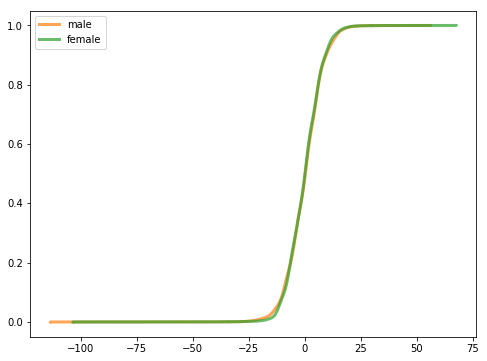

male 154407
smallest [  61.   74.   76.   81.   86.   89.   89.   91.   97.  101.]
largest [ 218.  221.  221.  221.  221.  225.  226.  229.  229.  236.]
173.0 178.0 183.0
classical estimators:  178.067393612 7.83319102919
MLE (178.06739361214332, 7.8331910291852775)


/Users/llv23/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
No handles with labels found to put in legend.


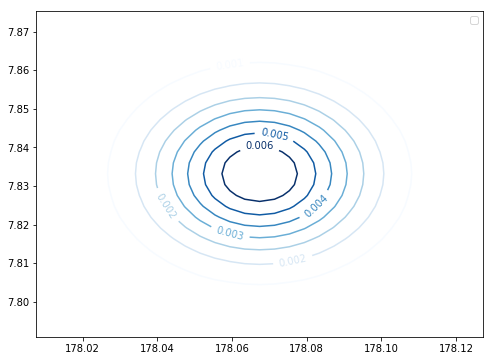

No handles with labels found to put in legend.


marginal mu 178.067393612 0.000389412872583
marginal sigma 7.83323532245 0.000194707011931


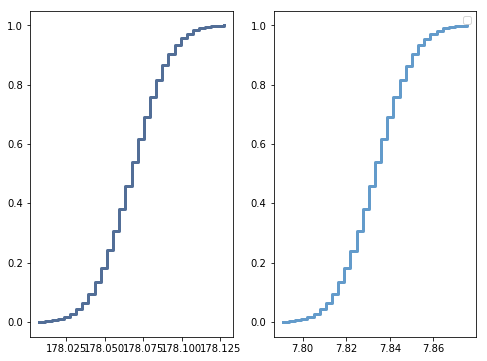

female 254722
smallest [ 61.  61.  64.  66.  74.  81.  89.  89.  89.  91.]
largest [ 213.  213.  213.  213.  221.  226.  229.  229.  229.  229.]
157.0 163.0 168.0
classical estimators:  163.22187134 7.3855488866
MLE (163.22187133954358, 7.3855488866023506)


No handles with labels found to put in legend.


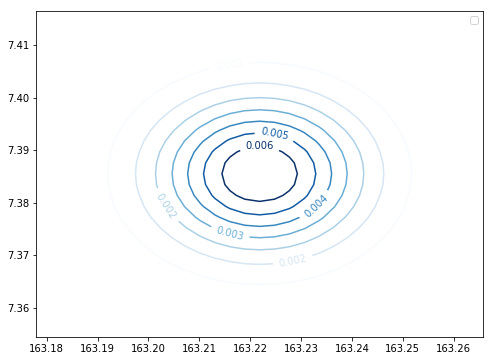

marginal mu 163.22187134 0.000209844264337
marginal sigma 7.38557420201 0.000104922320203


No handles with labels found to put in legend.


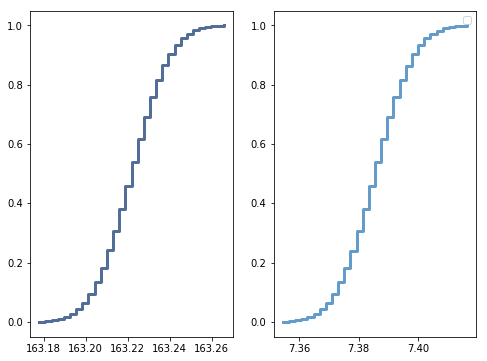

CV posterior mean 0.0439902851373
CV posterior mean 0.0452486802141
female bigger 1.000000000000001
male bigger 0


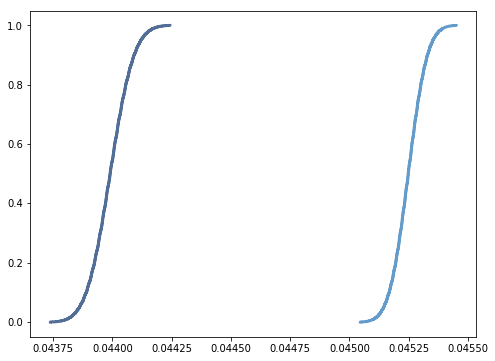

In [21]:
func = UpdateSuite4
# case 4: ABC estimate for distribution matching case => very faster
RunEstimate(func, median_flag=median_flag)

In [22]:
def UpdateSuite5(suite, xs):
    """Computes the posterior distibution of mu and sigma.
    Computes log likelihoods efficiently.
    suite: Suite that maps from (mu, sigma) to prob
    t: sequence
    """
    suite.Log()
    suite.LogUpdateSetMedianIPR(xs)
    suite.Exp()
    suite.Normalize()

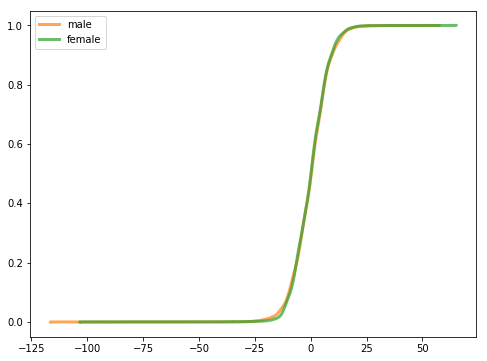

male 154407
smallest [  61.   74.   76.   81.   86.   89.   89.   91.   97.  101.]
largest [ 218.  221.  221.  221.  221.  225.  226.  229.  229.  236.]
173.0 178.0 183.0
classical estimators:  178.062524906 7.83105574936


/Users/llv23/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
No handles with labels found to put in legend.


median, s 178.351584088 7.42702971826
MLE (178.12231208742026, 7.7887796912255842)


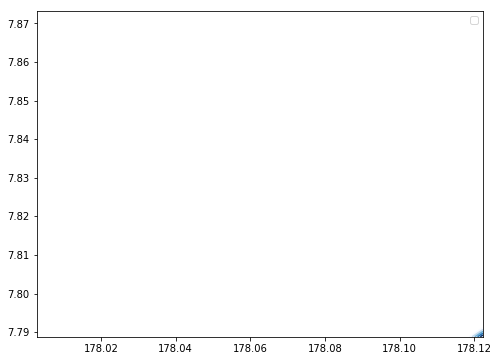

No handles with labels found to put in legend.


marginal mu 178.121893926 1.82501933432e-06
marginal sigma 7.78880045272 5.89168174058e-08


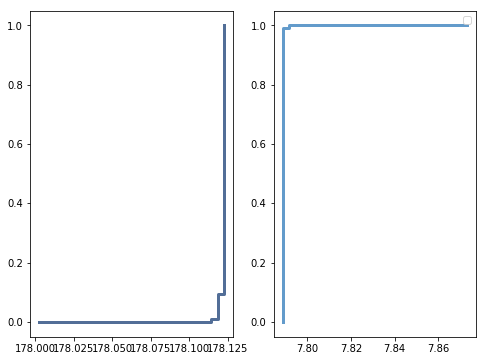

female 254722
smallest [ 61.  61.  64.  66.  74.  81.  89.  89.  89.  91.]
largest [ 213.  213.  213.  213.  221.  226.  229.  229.  229.  229.]
157.0 163.0 168.0
classical estimators:  163.225984085 7.38735390957


No handles with labels found to put in legend.


median, s 163.355019587 7.16142618772
MLE (163.26989544906124, 7.3563038250436961)


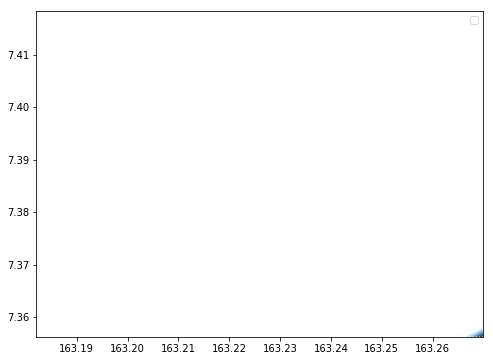

No handles with labels found to put in legend.


marginal mu 163.268677988 4.83401493824e-06
marginal sigma 7.35635589691 1.10299425003e-07


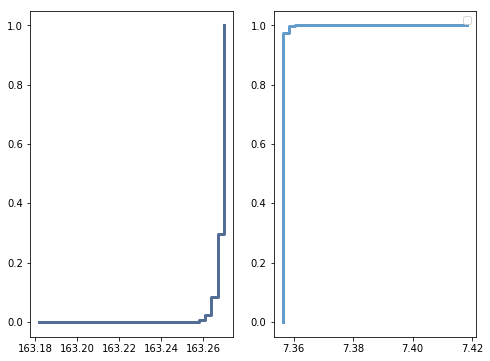

CV posterior mean 0.043727361536
CV posterior mean 0.0450567493344
female bigger 0.999999999999998
male bigger 0


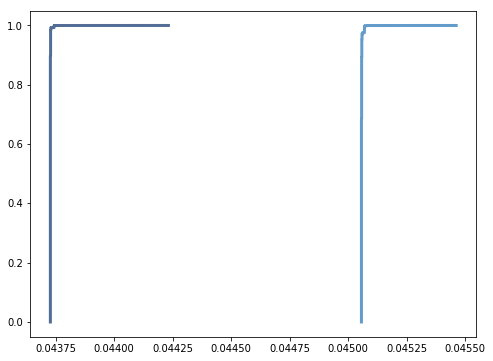

In [23]:
func = UpdateSuite5
# case 5: ABC estimate for distribution matching case => very faster
RunEstimate(func, median_flag=median_flag)